In [14]:
import kagglehub
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error
from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, classification_report
from sklearn.datasets import load_diabetes

# RANDOM FOREST CLASSIFIER

In [2]:
# Download latest version
path = kagglehub.dataset_download("developerghost/intrusion-detection-logs-normal-bot-scan")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\B.Salami\.cache\kagglehub\datasets\developerghost\intrusion-detection-logs-normal-bot-scan\versions\1


In [3]:
data_path = os.path.join(path, os.listdir(path)[0])
# read the file

data = pd.read_csv(data_path)
data.head()

,Source_IP,Destination_IP,Port,Request_Type,Protocol,Payload_Size,User_Agent,Status,Intrusion,Scan_Type
0,192.168.142.55,42.156.67.167,80,FTP,UDP,2369,curl/7.68.0,Success,0,Normal
1,53.39.165.18,94.60.242.119,135,SMTP,UDP,1536,Wget/1.20.3,Failure,1,BotAttack
2,192.168.127.91,7.10.192.3,21,SMTP,TCP,1183,Wget/1.20.3,Success,0,Normal
3,192.168.30.40,130.169.82.211,25,HTTPS,TCP,666,Mozilla/5.0,Success,0,Normal
4,192.168.43.179,35.140.102.220,22,FTP,TCP,2821,Mozilla/5.0,Success,0,Normal


In [4]:
data['Scan_Type'].value_counts()

Scan_Type
Normal       8000
BotAttack     478
PortScan      368
Name: count, dtype: int64

We have an imbalanced distribution which can affect the metrics of our model. So, we need to make the distribution reasonable

In [5]:
Normal_Rows=data[data['Scan_Type']=='Normal']
BotAttack_Rows=data[data['Scan_Type']=='BotAttack']
PortScan_Rows=data[data['Scan_Type']=='PortScan']

In [6]:
NR_Reduced=Normal_Rows.iloc[:500]

Ok_dis=pd.concat([NR_Reduced, BotAttack_Rows, PortScan_Rows],ignore_index=True)

Ok_dis.head()

,Source_IP,Destination_IP,Port,Request_Type,Protocol,Payload_Size,User_Agent,Status,Intrusion,Scan_Type
0,192.168.142.55,42.156.67.167,80,FTP,UDP,2369,curl/7.68.0,Success,0,Normal
1,192.168.127.91,7.10.192.3,21,SMTP,TCP,1183,Wget/1.20.3,Success,0,Normal
2,192.168.30.40,130.169.82.211,25,HTTPS,TCP,666,Mozilla/5.0,Success,0,Normal
3,192.168.43.179,35.140.102.220,22,FTP,TCP,2821,Mozilla/5.0,Success,0,Normal
4,192.168.74.4,1.236.8.103,53,HTTPS,UDP,2179,Mozilla/5.0,Success,0,Normal


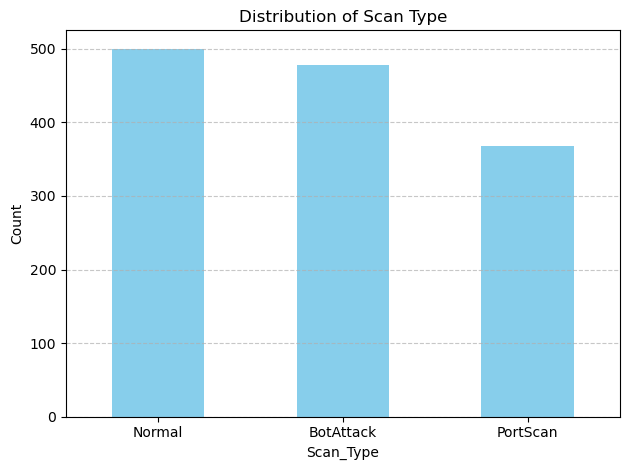

In [7]:
Ok_dis['Scan_Type'].value_counts().plot(kind='bar', color='skyblue')

plt.title('Distribution of Scan Type')
plt.xlabel('Scan_Type')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [8]:
#Encode the categorical variables
Encode_cols=list(Ok_dis.select_dtypes(include='object').columns)

for i in Encode_cols:
    encoder=LabelEncoder()
    Ok_dis[i]=encoder.fit_transform(Ok_dis[i])


Ok_dis.head()

,Source_IP,Destination_IP,Port,Request_Type,Protocol,Payload_Size,User_Agent,Status,Intrusion,Scan_Type
0,86,1125,80,1,2,2369,3,1,0,1
1,60,1232,21,4,1,1183,2,1,0,1
2,343,143,25,3,1,666,0,1,0,1
3,366,1099,22,1,1,2821,0,1,0,1
4,436,2,53,3,2,2179,0,1,0,1


In [9]:
# Split the dataset
X=Ok_dis.drop(columns=['Scan_Type'])
y=Ok_dis['Scan_Type']

# Train and split dataset
X_train, X_test,y_train, y_test=train_test_split(X, y, test_size=0.39, random_state=18, stratify=y)

In [10]:
#Scale the dataset

Scaler=RobustScaler()
Columns=X_train.columns

Scaler.fit(X_train)
X_train=Scaler.transform(X_train)
X_test=Scaler.transform(X_test)

#Convert to dataframe
X_train=pd.DataFrame(data=X_train, columns=Columns)
X_test=pd.DataFrame(data=X_test, columns=Columns)

X_train.head()

,Source_IP,Destination_IP,Port,Request_Type,Protocol,Payload_Size,User_Agent,Status,Intrusion
0,0.174447,-0.091324,4.697681,-0.50,-0.5,0.557471,-1.000000,0.0,0.0
1,-0.683047,-0.173516,-0.016561,-0.25,-0.5,-0.373153,-0.666667,1.0,-1.0
2,0.174447,0.065449,0.000000,-0.75,0.0,0.643268,-1.000000,0.0,0.0
3,-1.058968,-0.482496,0.000000,0.25,-0.5,0.598522,-0.666667,1.0,0.0
4,-1.046683,0.073059,-0.016862,0.50,0.5,-0.581281,-1.000000,0.0,0.0


In [11]:
# Model Training
Model=RandomForestClassifier(random_state=18, n_estimators=2, max_depth=2) #Init the model
Model.fit(X_train, y_train)

Train_Pred=Model.predict(X_train) #Train prediction
Test_Pred=Model.predict(X_test)   #Test prediction


Text(1068.1767676767674, 0.5, 'Prediction')

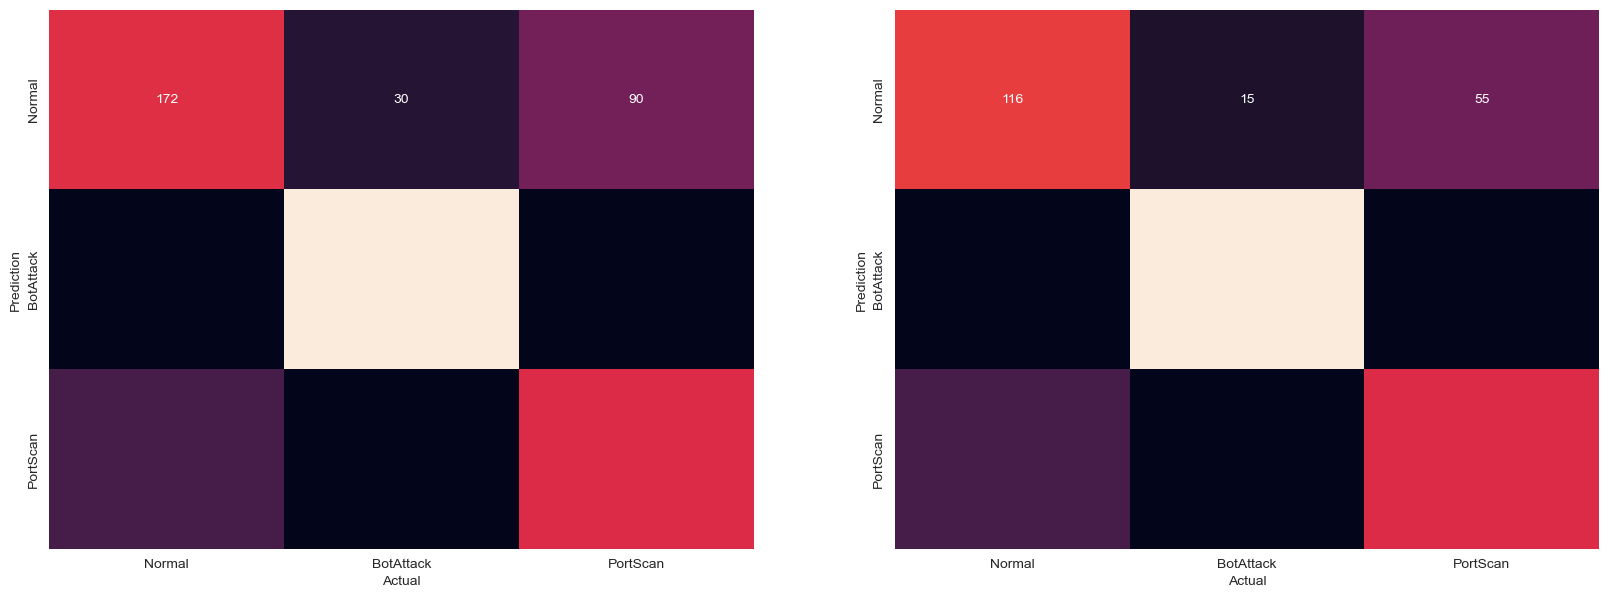

In [12]:
cols=['Normal', 'BotAttack', 'PortScan']
conf_train=pd.DataFrame(data=confusion_matrix(y_train,Train_Pred), columns=cols, index=cols)
conf_test=pd.DataFrame(data=confusion_matrix(y_test,Test_Pred), columns=cols, index=cols)

sns.set_style('darkgrid')
fig, axes=plt.subplots(nrows=1, ncols=2, figsize=(20,7))
sns.heatmap(data=conf_train, ax=axes[0], cbar=False, annot=True, fmt='d')
sns.heatmap(data=conf_test, ax=axes[1], cbar=False, annot=True, fmt='d')
                      
axes[0].set_xlabel('Actual')
axes[0].set_ylabel('Prediction')
axes[1].set_xlabel('Actual')
axes[1].set_ylabel('Prediction')

In [13]:
train_classification=classification_report(y_train, Train_Pred)
test_classification=classification_report(y_test, Test_Pred)

print(f'Train Classification: \n{train_classification}')
print(f'Test Classification: \n{test_classification}')

Train Classification: 
              precision    recall  f1-score   support

           0       0.75      0.59      0.66       292
           1       0.91      1.00      0.95       305
           2       0.65      0.75      0.70       224

    accuracy                           0.79       821
   macro avg       0.77      0.78      0.77       821
weighted avg       0.78      0.79      0.78       821

Test Classification: 
              precision    recall  f1-score   support

           0       0.76      0.62      0.69       186
           1       0.93      1.00      0.96       195
           2       0.66      0.75      0.70       144

    accuracy                           0.80       525
   macro avg       0.78      0.79      0.78       525
weighted avg       0.80      0.80      0.79       525



# RANDOM FOREST REGRESSOR

In [15]:
#Load the dataset
X=load_diabetes(as_frame=True)['data']
y=load_diabetes()['target']

X.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641


In [16]:
#Split the data
X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.25, random_state=13) 

In [17]:
#Train the model
model=RandomForestRegressor(n_estimators=7, random_state=13, max_depth=3)
model.fit(X_train,y_train)
train_pred=model.predict(X_train)
test_pred=model.predict(X_test)

In [22]:
#Evaluate the model
print(f'Train RSME:\n{root_mean_squared_error(y_train,train_pred)}')
print(f'Test RSME:\n{root_mean_squared_error(y_test,test_pred)}')

Train RSME:
51.013798779344164
Test RSME:
55.543549091581994
